In [92]:
%matplotlib inline
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import warnings
warnings.filterwarnings('ignore')

Base = automap_base()
engine = create_engine("mysql+mysqldb://bz:@127.0.0.1/db_trading")
Base.prepare(engine, reflect=True)
price_data = Base.classes.price_data

Session = sessionmaker()
Session.configure(bind=engine)
session = Session()

# Risk on/off correlation

- Let's select a few AUD pairs, plot their returns and have a look at the correlation matrix.

In [106]:
start_date = '2016-04-01'
end_date = '2016-07-31'
risky_basket = ['AU200_AUD', 'AUD_USD', 'AUD_JPY', 'EUR_AUD', 'GBP_AUD']
q = session.query(price_data.instrument, price_data.ori_oanda_time, price_data.open_ask,
                 price_data.close_ask, price_data.open_bid, price_data.close_bid).filter(
                price_data.ori_oanda_time >= start_date).filter(price_data.ori_oanda_time
                <= end_date).filter(price_data.instrument.in_((risky_basket)))

In [107]:
df = pd.read_sql(q.statement, engine, parse_dates=['ori_oanda_time'], index_col=['ori_oanda_time'])

In [108]:
cols = ['au200_aud', 'aud_usd', 'aud_jpy', 'eur_aud', 'gbp_aud']
returns_dict = {}
for ins in df.instrument.unique().tolist():
    returns_dict[str(ins)] = df.loc[df.instrument == ins]['close_bid']
returns_df = pd.DataFrame(returns_dict, index=df.index)

In [109]:
returns = returns_df / returns_df.shift(1)
returns.columns = cols
log_returns = np.log(returns)
log_returns.columns = cols

### Graph of the returns for the period between April and August
- It seems that AUD_JPY and EUR_AUD are strongly negatively correlated, the other correlations seem weak, but this is for a very long period, for shorter periods the correlations are stronger.
- From the graph we can see that there are periods of high volatility, let's zoom to have a closer look to see what exatcly happens when FX markets are swinging.

,au200_aud,aud_usd,aud_jpy,eur_aud,gbp_aud
au200_aud,1.000000,-0.305003,0.025940,-0.188041,-0.401205
aud_usd,-0.305003,1.000000,0.655629,-0.509144,0.304679
aud_jpy,0.025940,0.655629,1.000000,-0.693229,-0.196109
eur_aud,-0.188041,-0.509144,-0.693229,1.000000,0.533072
gbp_aud,-0.401205,0.304679,-0.196109,0.533072,1.000000


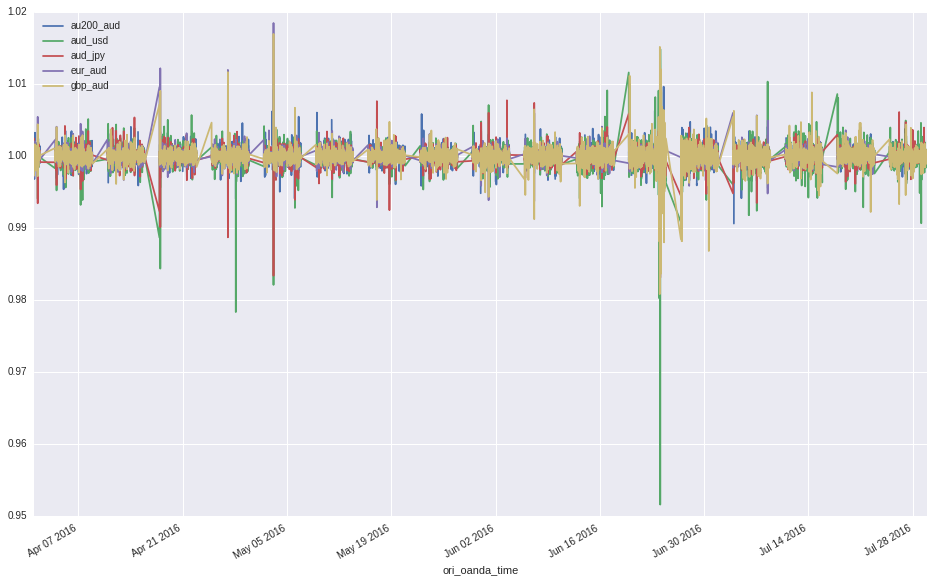

In [111]:
returns.loc[returns.index > '2016-04-01'].plot(kind='line', figsize=(16, 10))
returns.corr()

### Brexit

#### First thing that comes to mind is to zoom in when the Brexit vote occured

- Markets still didn't know the outcome of the vote.
- AUD loses to USD and JPY, meaning that there's a strong flight to safety, esspecialy to USD.
- GBP also gains against AUD, initial polls suggested stay vote. 
- AUD gains against EUR.

,au200_aud,aud_usd,aud_jpy,eur_aud,gbp_aud
au200_aud,1.000000,0.476204,0.479609,0.022604,0.692948
aud_usd,0.476204,1.000000,0.952211,-0.496447,0.417572
aud_jpy,0.479609,0.952211,1.000000,-0.542612,0.411357
eur_aud,0.022604,-0.496447,-0.542612,1.000000,0.140170
gbp_aud,0.692948,0.417572,0.411357,0.140170,1.000000


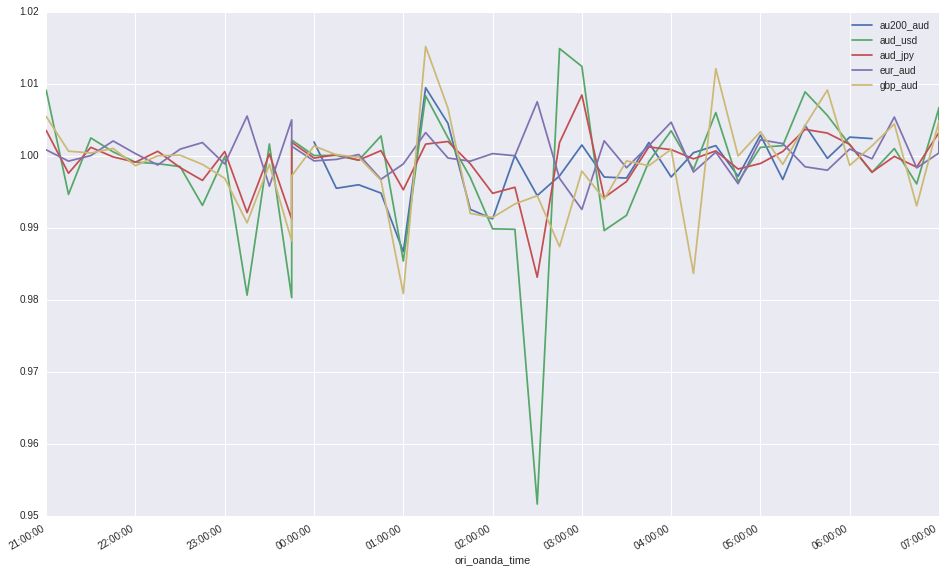

In [112]:
brexit_date = datetime.datetime(year=2016, month=6, day=23, hour=21)
brexit_date_to = brexit_date + datetime.timedelta(hours=10)
returns.loc[(returns_df.index >= brexit_date) & (returns.index <= brexit_date_to)].plot(kind='line', figsize=(16, 10))
returns.loc[(returns_df.index >= brexit_date) & (returns.index <= brexit_date_to)].corr()

#### A little bit before brexit vote - May 31

- Two notable periods of movement on the graph
- GBP loses to AUD
- AUD sharply gains also against USD and JPY.
- A little research shows that on this date Brexit poll results were announced showing leave vote majority http://www.businessinsider.com/fx-markets-may-31-2016-5
- EUR_AUD is positively correlated with AUD.

,au200_aud,aud_usd,aud_jpy,eur_aud,gbp_aud
au200_aud,1.000000,0.437104,0.380015,-0.358245,-0.170856
aud_usd,0.437104,1.000000,0.865140,-0.835138,-0.431191
aud_jpy,0.380015,0.865140,1.000000,-0.873412,-0.638826
eur_aud,-0.358245,-0.835138,-0.873412,1.000000,0.659398
gbp_aud,-0.170856,-0.431191,-0.638826,0.659398,1.000000


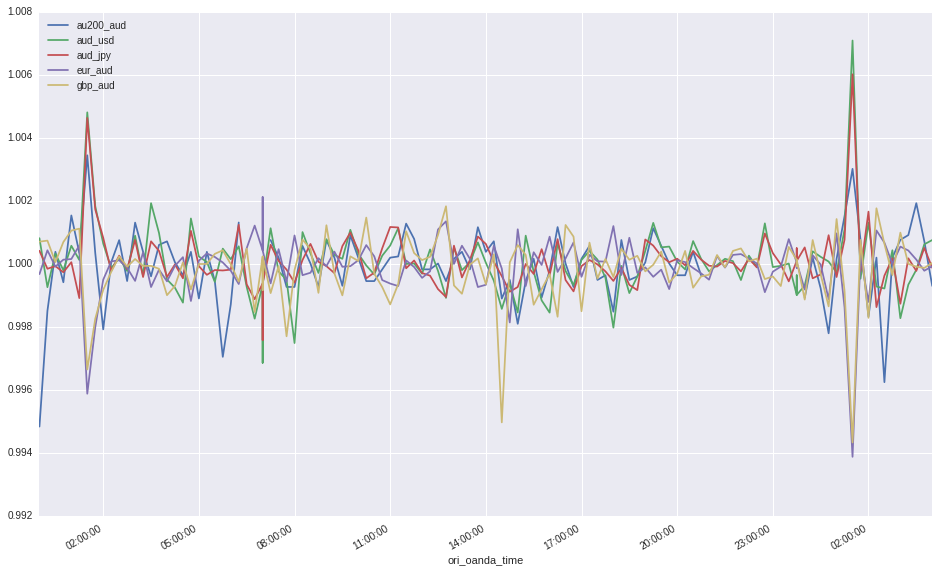

In [113]:
returns.loc[(df.index >= '2016-05-31') & (df.index <= '2016-06-01 04:00:00')].plot(kind='line', figsize=(16, 10))
returns.loc[(df.index >= '2016-05-31') & (df.index <= '2016-06-01 04:00:00')].corr()

### Zooming in on another period of volatility

- The picture seems to tell the same story
- Another period of volatility where AUD gains against the major currencies.
- A bet on AUD during these kinds of volatile times seems profitable.

,au200_aud,aud_usd,aud_jpy,eur_aud,gbp_aud
au200_aud,1.000000,0.783061,0.444465,-0.625999,-0.472507
aud_usd,0.783061,1.000000,0.362466,-0.807895,-0.567678
aud_jpy,0.444465,0.362466,1.000000,-0.189936,-0.195811
eur_aud,-0.625999,-0.807895,-0.189936,1.000000,0.636904
gbp_aud,-0.472507,-0.567678,-0.195811,0.636904,1.000000


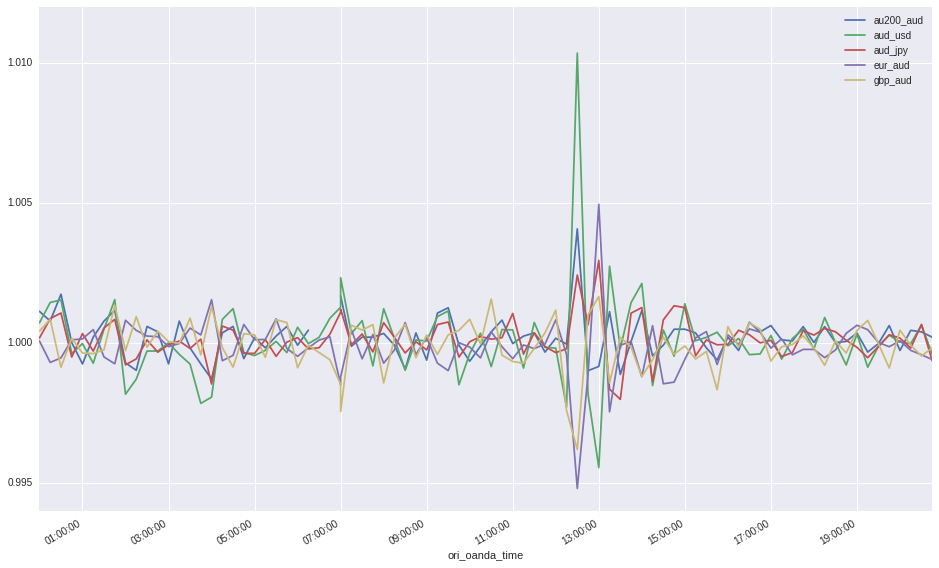

In [115]:
returns.loc[(df.index >= '2016-07-08') & (df.index <= '2016-07-09')].plot(kind='line', figsize=(16, 10))
returns.loc[(df.index >= '2016-07-08') & (df.index <= '2016-07-09')].corr()

### A different story, AUD loses against major currencies

- Here we see a different story, AUD loses against all currencies. 
- Strong correlations in AUD_USD, AUD_JPY and EUR_AUD, going even above 0.9.

,au200_aud,aud_usd,aud_jpy,eur_aud,gbp_aud
au200_aud,1.000000,0.191617,0.140268,-0.131740,-0.023094
aud_usd,0.191617,1.000000,0.863753,-0.823601,-0.522119
aud_jpy,0.140268,0.863753,1.000000,-0.951869,-0.781070
eur_aud,-0.131740,-0.823601,-0.951869,1.000000,0.842029
gbp_aud,-0.023094,-0.522119,-0.781070,0.842029,1.000000


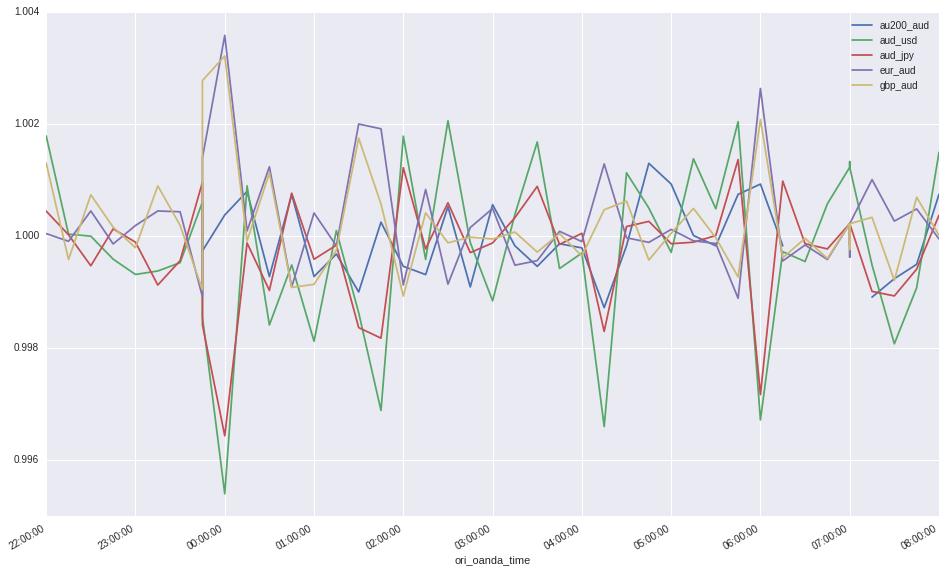

In [116]:
returns.loc[(df.index >= '2016-07-18 22:00:00') & (df.index <= '2016-07-19 08:00:00')].plot(kind='line', figsize=(16, 10))
returns.loc[(df.index >= '2016-07-18 22:00:00') & (df.index <= '2016-07-19 08:00:00')].corr()

### Jointplots for the whole period

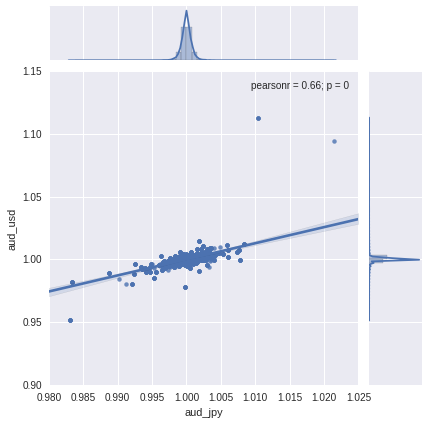

In [117]:
sns.jointplot(returns['aud_jpy'], returns['aud_usd'], kind='reg')

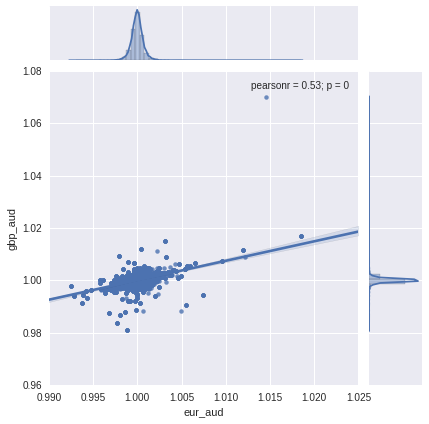

In [118]:
sns.jointplot(returns['eur_aud'], returns['gbp_aud'], kind='reg')

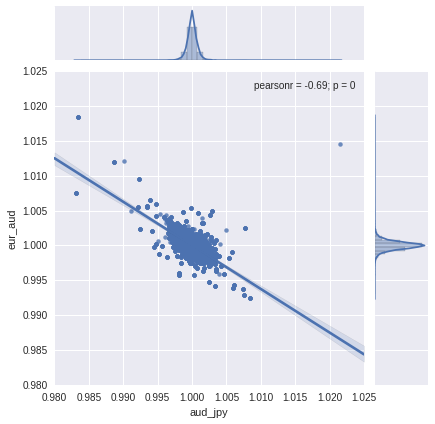

In [120]:
sns.jointplot(returns['aud_jpy'], returns['eur_aud'], kind='reg')

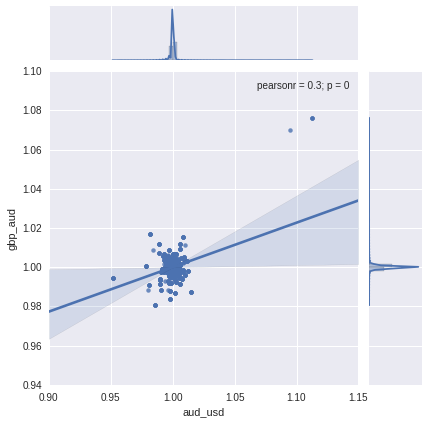

In [121]:
sns.jointplot(returns['aud_usd'], returns['gbp_aud'], kind='reg')

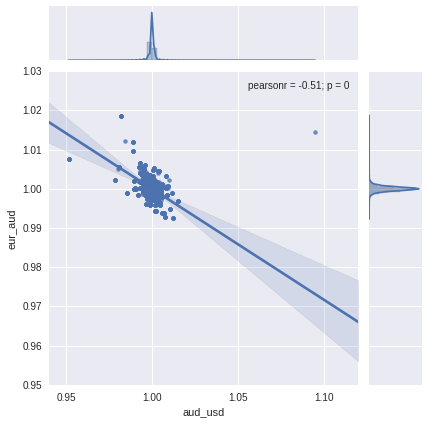

In [122]:
sns.jointplot(returns['aud_usd'], returns['eur_aud'], kind='reg')